# sources
https://gamma.cs.unc.edu/SOUND09/PAPERS/nikunj_TVCG.pdf
- describes ARD (adaptive rectangular decomposition)
- essentially: solutions are known for wave equation w/ 100% reflective rectangular boundary conditions; decompose the scene into such rectangles then couple them together through generalized "force"
- saw this in 110B - electromagnetic plane waves (i.e. vacuum) w/ conductor as boundary condition
- external interfaces - use PML (perfectly matched layer) to fully attenuate waves going out into air, or to model (partially) absorbtive surfaces

https://www.microsoft.com/en-us/research/wp-content/uploads/2016/10/4.pdf
- describes ARD being implemented on a GPU

https://math.mit.edu/~stevenj/18.369/spring09/pml.pdf
- PML theory
- it seems like the idea is just to apply a different wave equation within the PML
- "coordinate transform": like evaluating maxwell's equations in a complex contour, rather than only along the real line (for 1D case)
- transforming back to real coordinates, the analogous thing is a weird anisotropic material with some strange conductivity (pretty cool!)

https://pubs.aip.org/asa/jasa/article/138/2/708/917382/Overview-of-geometrical-room-acoustic-modeling
- survey paper of geometric acoustics
- need to read more carefully



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import sympy

from matplotlib import animation
from mpl_toolkits.axes_grid1 import make_axes_locatable
from IPython.display import HTML

c = 343 # m/s

%matplotlib notebook

In [ ]:
def fdtd_spacing(f_max: float, s: float) -> float:
  wavelength: float = c / f_max
  return wavelength / s

In [ ]:
# experiment: solve basic rectangle case in 2D with a point-like
# source, both using normal FDTD + von Neumann boundary
# and analytic method in ARD (they should agree, mostly)

# x: width, in meters
# y: height, in meters
# f_max: maximum frequency in Hz (determines discretization)
# s: # of samples per wavelength (determines discretization)
#    the bare minimum is 2, but will lead to large numerical dispersion

def fdtd_rectangle(x: float, y: float, f_max: float, courant: float, viz: bool = True):
  h: float = fdtd_spacing(f_max, 8)

  # create computational grid (size of rectangle quantized by FDTD spacing)
  xs: int = int(x / h)
  ys: int = int(y / h)

  # "soft" monopole source; completely nonphysical
  # (units same as field)
  source_strength: float = 0.01
  source_freq: float = f_max / 8 # in Hz
  source_x: int = xs // 2
  source_y: int = ys // 2

  p_0: np.ndarray = np.zeros((ys, xs))
  p_1: np.ndarray = np.zeros((ys, xs))

  print(f"real width: {xs*h}")
  print(f"real height: {ys*h}")
  print(f"x cells: {xs}, y cells: {ys}")
  print(f'monopole source at ({source_x * h}, {source_y * h})')
  print(f'    strength: {source_strength}, frequency: {source_freq}')

  # CFL condition - numerical speed > physical speed
  # (sqrt(2) * h) / (2 * dt) > c
  # dt < h / (c * sqrt(2))
  assert courant <= 1.0, "CFL condition violated"
  dt: float = courant * h / (c * np.sqrt(2))

  # d = 3 stencil (discretization of 2nd derivative)
  stencil: np.ndarray = np.array([2, -27, 270, -490, 270, -27, 2]) / 180

  fig, ax = plt.subplots(figsize=(6,4))
  divider = make_axes_locatable(ax)
  cax = divider.append_axes('right', size='5%', pad=0.05)
  ax.set_title(f'step 0 (t = 0)')
  ax.set_xlabel('x (m)')
  ax.set_ylabel('y (m)')
  im = ax.imshow(p_1, origin='lower', extent=[0, x, 0, y], cmap='RdBu_r', vmin=-1, vmax=1)
  fig.colorbar(im, cax)

  step: int = 0
  def run_step():
    nonlocal p_0, p_1, step

    # mode='reflect' to enforce von Neumann boundary condition
    # we
    d2x = scipy.ndimage.convolve(p_1, stencil, mode='reflect', axes=(1,))
    d2y = scipy.ndimage.convolve(p_1, stencil, mode='reflect', axes=(0,))

    # leapfrog integration
    p_0 = 2.0 * p_1 - p_0 + ((c * c * dt * dt) / (h * h)) * (d2x + d2y)
    p_0, p_1 = p_1, p_0

    # inject monopole source
    # p_1[source_y, source_x] += source_strength * np.cos(2 * np.pi * source_freq * step * dt)
    if step == 0:
      p_1[source_y, source_x] += source_strength * 100.0
    step += 1

  visualize_every: int = 100
  def visualize_pressure(_i):
    for _ in range(visualize_every):
      run_step()

    ax.set_title(f'step {step} (t = {step*dt})')
    im.set_data(p_1)

  steps = 10000
  if viz:
    anim = animation.FuncAnimation(fig, visualize_pressure, frames=steps//visualize_every, interval=200)
    return anim
  else:
    for _ in range(steps):
      run_step()
    return p_1

anim = fdtd_rectangle(10, 10, 1000, 0.2)
HTML(anim.to_html5_video())

real width: 9.989875000000001
real height: 9.989875000000001
x cells: 233, y cells: 233
monopole source at (4.9735000000000005, 4.9735000000000005)
    strength: 0.01, frequency: 125.0


<IPython.core.display.Javascript object>

In [ ]:
def dct(x: np.ndarray) -> np.ndarray:
  N = x.shape[0]

  v = np.empty_like(x)
  v[:(N-1)//2+1] = x[::2]

  if N % 2: # odd length
      v[(N-1)//2+1:] = x[-2::-2]
  else: # even length
      v[(N-1)//2+1:] = x[::-2]

  V = np.fft.fft(v)

  k = np.arange(N)
  V *= 2 * np.exp(-1j*np.pi*k/(2*N))
  return V.real

def idct(C: np.ndarray) -> np.ndarray:
  N = C.shape[0]

  k = np.arange(N)
  V = np.empty_like(C, dtype=np.complex64)
  V[0] = 0.5 * C[0]
  V[1:] = 0.5 * np.exp(-1j*np.pi*(-k[1:])/(2*N)) * (C[1:] - 1j * C[:0:-1])

  v = np.fft.ifft(V)
  x = np.empty_like(C)
  x[::2] = v[:(N-1)//2+1].real
  if N % 2:
    x[-2::-2] = v[(N-1)//2+1:].real
  else:
    x[::-2] = v[(N-1)//2+1:].real

  return x

def dct2(x: np.ndarray) -> np.ndarray:
    """2D DCT via separable 1D DCT."""
    # Apply DCT along rows
    y = np.apply_along_axis(dct, axis=1, arr=x)
    # Apply DCT along columns
    y = np.apply_along_axis(dct, axis=0, arr=y)
    return y

def idct2(X: np.ndarray) -> np.ndarray:
    """2D inverse DCT via separable 1D IDCT."""
    # Apply IDCT along rows
    y = np.apply_along_axis(idct, axis=1, arr=X)
    # Apply IDCT along columns
    y = np.apply_along_axis(idct, axis=0, arr=y)
    return y

In [ ]:
def analytic_rectangle(x: float, y: float, f_max: float, courant: float, viz: bool = True):
  h: float = fdtd_spacing(f_max, 8)

  # create computational grid (size of rectangle quantized by FDTD spacing)
  # note: we don't have grid points on the boundary (since we are using DCT-2),
  # so the results are not directly comparable to FDTD results
  # but, it should be possible to calculate the values at FDTD grid points
  # for comparison (maybe less efficiently)
  xs: int = int(x / h)
  ys: int = int(y / h)

  # CFL condition doesn't apply to analytic result, however you
  # still need to use a small enough timestep to ensure discretization
  # error of sources (and later, boundaries) is small. we use the
  # same calculation as for FDTD to be consistent
  dt: float = courant * h / (c * np.sqrt(2))

  # monopole source; completely nonphysical
  # units: field units / t^2
  source_strength: float = 0.01 / (dt * dt)
  source_freq: float = f_max / 8 # in Hz
  source_x: int = xs // 2
  source_y: int = ys // 2

  m_0: np.ndarray = np.zeros((ys, xs))
  m_1: np.ndarray = np.zeros((ys, xs))
  pressures: np.ndarray = np.zeros((ys, xs))
  source: np.ndarray = np.zeros((ys, xs))

  k_x: np.ndarray = np.arange(xs)
  k_y: np.ndarray = np.arange(ys)
  lx = xs*h
  ly = ys*h
  k2: np.ndarray = np.pi * np.pi * ((k_x*k_x/(lx*lx))[None, :] + (k_y*k_y/(ly*ly))[:, None])
  omega: np.ndarray = c * np.sqrt(k2)

  fig, ax = plt.subplots(figsize=(6,4))
  divider = make_axes_locatable(ax)
  cax = divider.append_axes('right', size='5%', pad=0.05)
  ax.set_title(f'step 0 (t = 0)')
  ax.set_xlabel('x (m)')
  ax.set_ylabel('y (m)')
  im = ax.imshow(pressures, origin='lower', extent=[0, x, 0, y], cmap='RdBu_r', vmin=-1, vmax=1)
  fig.colorbar(im, cax)

  step: int = 0
  def run_step():
    nonlocal source, omega, m_0, m_1, step, pressures

    # DCT of source
    # source[source_y, source_x] = source_strength * np.cos(2 * np.pi * source_freq * step * dt)
    if step == 0:
      source[source_y, source_x] += source_strength
    source_dct = scipy.fft.dctn(source)

    # update rule
    m_0 = 2.0 * m_1 * np.cos(omega * dt) - m_0 + (1.0 - np.cos(omega * dt)) * (2.0 * source_dct / (omega * omega + 1e-15))
    m_0, m_1 = m_1, m_0
    step += 1

  visualize_every: int = 100
  def visualize_pressure(_i):
    for _ in range(visualize_every):
      run_step()

    pressures = scipy.fft.idctn(m_1)
    ax.set_title(f'step {step} (t = {step*dt})')
    im.set_data(pressures)

  steps = 10000
  if viz:
    anim = animation.FuncAnimation(fig, visualize_pressure, frames=steps//visualize_every, interval=200)
    return anim
  else:
    for _ in range(steps):
      run_step()
    pressures = scipy.fft.idctn(m_1)
    return pressures

anim = analytic_rectangle(10, 10, 1000, 0.2)
HTML(anim.to_html5_video())

<IPython.core.display.Javascript object>

real width: 9.989875000000001
real height: 9.989875000000001
x cells: 233, y cells: 233
monopole source at (4.9735000000000005, 4.9735000000000005)
    strength: 0.01, frequency: 125.0
0.19113127858225418 0.19417329832274333


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<Figure size 640x480 with 0 Axes>

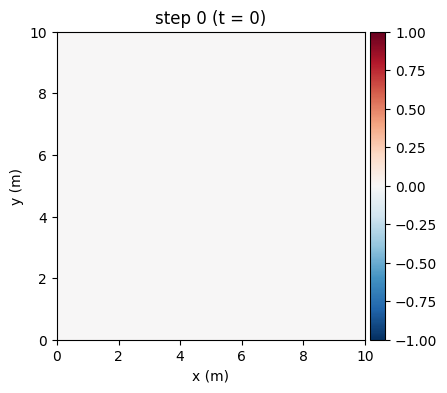

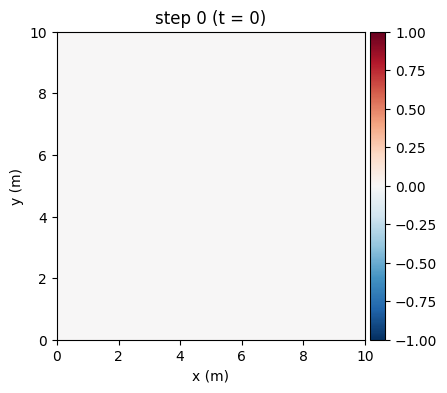

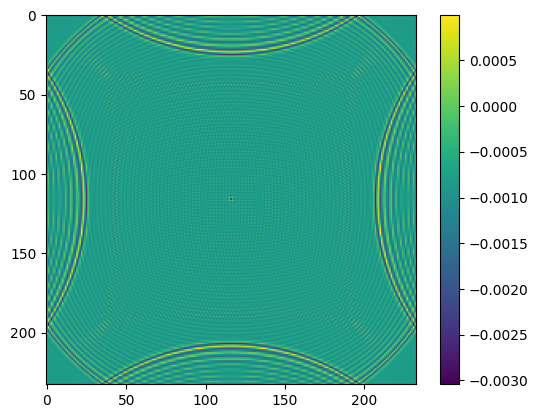

In [ ]:
analytic_pressure = analytic_rectangle(10, 10, 1000, 0.2, viz=False)
fdtd_pressure = fdtd_rectangle(10, 10, 1000, 0.2, viz=False)

%matplotlib inline
plt.figure()
plt.imshow(analytic_pressure - fdtd_pressure)
print(np.max(analytic_pressure), np.max(fdtd_pressure))
plt.colorbar()
plt.show()

In [ ]:
# experiment: couple two rectangles together through FDTD on boundary
# compare result with a single rectangle

%matplotlib notebook

# artificially split down 1/3 of height, then couple together through FDTD
def make_analytic_rectangle(
    x: float,
    y: float,
    f_max: float,
    courant: float
):
  h: float = fdtd_spacing(f_max, 8)

  # create computational grid (size of rectangle quantized by FDTD spacing)
  # note: we don't have grid points on the boundary (since we are using DCT-2),
  # so the results are not directly comparable to FDTD results
  # but, it should be possible to calculate the values at FDTD grid points
  # for comparison (maybe less efficiently)
  xs: int = int(x / h)
  ys: int = int(y / h)

  # CFL condition doesn't apply to analytic result, however you
  # still need to use a small enough timestep to ensure discretization
  # error of sources (and later, boundaries) is small. we use the
  # same calculation as for FDTD to be consistent
  dt: float = courant * h / (c * np.sqrt(2))

  m_0: np.ndarray = np.zeros((ys, xs))
  m_1: np.ndarray = np.zeros((ys, xs))
  pressures: np.ndarray = np.zeros((ys, xs))
  source: np.ndarray = np.zeros((ys, xs))

  k_x: np.ndarray = np.arange(xs)
  k_y: np.ndarray = np.arange(ys)
  lx = xs*h
  ly = ys*h
  k2: np.ndarray = np.pi * np.pi * ((k_x*k_x/(lx*lx))[None, :] + (k_y*k_y/(ly*ly))[:, None])
  omega: np.ndarray = c * np.sqrt(k2)

  sim = {}
  sim['h'] = h
  sim['m_0'] = m_0
  sim['m_1'] = m_1
  sim['pressures'] = pressures
  sim['source'] = source
  sim['omega'] = omega
  sim['dt'] = dt
  sim['step'] = 0

  return sim

def make_figure(x: float, y: float, pressures: np.ndarray):
  fig, ax = plt.subplots(figsize=(6,4))
  divider = make_axes_locatable(ax)
  cax = divider.append_axes('right', size='5%', pad=0.05)
  ax.set_title(f'step 0 (t = 0)')
  ax.set_xlabel('x (m)')
  ax.set_ylabel('y (m)')
  im = ax.imshow(pressures, origin='lower', extent=[0, x, 0, y], cmap='RdBu_r', vmin=-1, vmax=1)
  fig.colorbar(im, cax)

  return fig, ax, im

def make_source(x1: float, x2: float, y: float, f_max: float, sim1, sim2):
  # monopole source; completely nonphysical
  if (x1 + x2) / 2 < x1:
    sim = sim1
    rel_x = (x1 + x2) / 2
  else:
    sim = sim2
    rel_x = (x1 + x2) / 2 - x1

  h = sim['h']
  dt = sim['dt']
  # units: field units / t^2
  source_strength: float = 0.01 / (dt * dt)
  source_freq: float = f_max / 8 # in Hz
  source_x: int = int(rel_x / h)
  source_y: int = int(y / h) // 2
  sim['source_info'] = {
      'strength': source_strength,
      'freq': source_freq,
      'x': source_x,
      'y': source_y
  }

def step_analytic_rectangle(step: int, sim):
  m_0 = sim['m_0']
  m_1 = sim['m_1']
  pressures = sim['pressures']
  source = sim['source']
  omega = sim['omega']
  dt = sim['dt']
  step = sim['step']

  # DCT of source
  if 'source_info' in sim:
    source_info = sim['source_info']
    source_x = source_info['x']
    source_y = source_info['y']
    source_strength = source_info['strength']
    source_freq = source_info['freq']

    source[source_y, source_x] = source_strength * np.cos(2 * np.pi * source_freq * step * dt)

  source_dct = scipy.fft.dctn(source)


  # update rule

  # compute modal forcing factor safely (handle omega -> 0)
  # exact factor for constant-in-time forcing over a step is (1 - cos(omega*dt)) / omega^2
  # use limit dt^2/2 for omega->0
  omega2 = omega * omega
  small = omega < 1e-12
  factor = np.empty_like(omega)
  # safe formula
  factor[~small] = (1.0 - np.cos(omega[~small] * dt)) / (omega2[~small])
  factor[small]  = 0.5 * (dt * dt)   # limit as omega->0
  # print(small)

  m_0 = 2.0 * m_1 * np.cos(omega * dt) - m_0 + source_dct * factor
  m_0, m_1 = m_1, m_0

  # update pressures
  pressures = scipy.fft.idctn(m_1)

  step += 1

  source.fill(0.0)

  sim['source'] = source
  sim['pressures'] = pressures
  sim['m_0'] = m_0
  sim['m_1'] = m_1
  sim['step'] = step

def couple_rectangles(sim1, sim2):
  # d = 3 stencil (discretization of 2nd derivative)
  # note, it's actually slightly different from what is used in the FDTD
  # case because the interface is *in between* the two rectangles
  assert sim1['h'] == sim2['h'], "cell size must be equal"
  assert sim1['dt'] == sim2['dt'], "timestep must be equal"
  h = sim1['h']
  dt = sim1['dt']

  d = 3
  width = 2*d+1
  halo = width-1
  stencil: np.ndarray = np.array([+2, -27, +270, -490, +270, +27, +2]) / 180

  l_pressure = sim1['pressures']
  r_pressure = sim2['pressures']

  l_pressure, r_pressure = l_pressure[:, -halo:], r_pressure[:, :halo]

  # print(l_pressure[:5, -d:])
  # print(r_pressure[:5, :d])

  overlap = np.concat((l_pressure, r_pressure), axis=1)

  # print(overlap[:5, :])

  lap_refl_l = scipy.ndimage.convolve(l_pressure, stencil, axes=1, mode='reflect') / (h * h)
  lap_refl_r = scipy.ndimage.convolve(r_pressure, stencil, axes=1, mode='reflect') / (h * h)
  lap = scipy.ndimage.convolve(overlap, stencil, axes=1) / (h * h)
  # print(force)
  lap_l, lap_r = np.split(lap, 2, axis=1)
  lap_l, lap_r = lap_l[:, -d:], lap_r[:, :d]
  lap_refl_l, lap_refl_r = lap_refl_l[:, -d:], lap_refl_r[:, :d]
  # print(force[:5])
  # print(force_l[:5, -1])
  # print(force_r[:5, 0])
  # print(lap_l.shape, lap_r.shape, lap_refl_l.shape, lap_refl_r.shape)
  sim1['source'][:, -d:] = c * c * (lap_l - lap_refl_l)
  sim2['source'][:, :d] = c * c * (lap_r - lap_refl_r)


def coupled_analytic_rectangles():
  sim1 = make_analytic_rectangle(10 / 3, 10, 1000, 0.2)
  sim2 = make_analytic_rectangle(2 * 10 / 3, 10, 1000, 0.2)
  make_source(10 / 3, 2 * 10 / 3, 10, 1000, sim1, sim2)

  combined_pressures = np.concat((sim1['pressures'], sim2['pressures']), axis=1)
  fig, ax, im = make_figure(10, 10, combined_pressures)

  step: int = 0
  def run_step():
    nonlocal step

    couple_rectangles(sim1, sim2)
    step_analytic_rectangle(step, sim1)
    step_analytic_rectangle(step, sim2)
    step += 1

  visualize_every: int = 100
  def visualize_pressure(_i):
    nonlocal combined_pressures
    dt = sim1['dt']
    for _ in range(visualize_every):
      run_step()

    combined_pressures = np.concat((sim1['pressures'], sim2['pressures']), axis=1)
    ax.set_title(f'step {step} (t = {step*dt})')
    im.set_data(combined_pressures)

  steps: int = 5000
  anim = animation.FuncAnimation(fig, visualize_pressure, frames=steps//visualize_every, interval=200)
  return anim


anim = coupled_analytic_rectangles()
HTML(anim.to_html5_video())

<IPython.core.display.Javascript object>

https://en.wikipedia.org/wiki/Acoustic_wave_equation
- we use the 1st order system they define, w/ u being flow velocity and p being pressure (just so the $\vec{v}$ field has a nicer physical meaning)

$a = \frac{1}{\rho_0}$, $b = K_0$, $c_0 = \sqrt{\frac{K_0}{\rho_0}}$

$\frac{\partial p}{\partial t} = K_0 \nabla \cdot \vec{v} - \sigma_x p + \psi$

$\frac{\partial v_x}{\partial t} = \frac{1}{\rho_0} \frac{\partial p}{\partial x} - \sigma_x v_x$

$\frac{\partial v_y}{\partial t} = \frac{1}{\rho_0} \frac{\partial p}{\partial y}$

$\frac{\partial \psi}{\partial t} = K_0 \sigma_x \frac{\partial v_y}{\partial y}$

- How do we discretize this? we need to track $\vec{v}$ and $\psi$ in the PML region

ChatGPT suggested the following scheme:
- store $p$ and $\psi$ at the center of each cell
- store $v_x$ between two cells horizontally (center of vertical face)
- store $v_y$ between two cells vertically (center of horizontal face)
- $v_x$, $v_y$ are evaluated at half-timesteps, $p$ and $\psi$ are evaluated at integer timesteps
- this is basically the same structure as Yee cells in classical electromagnetic FDTD

1. update $v_x^{(i+1/2)}$ from $p^{(i)}$ (need to find $\frac{\partial p}{\partial x}$ w/ discrete difference), multiply by $e^{-\sigma_x \Delta t}$ to account for $-\sigma_x v_x$ term
2. update $v_y^{(i+1/2)}$ from $p^{(i)}$ in a similar way
3. update $\psi^{(i+1)}$ from $v_y^{(i+1/2)}$
4. update $p^{(i+1)}$ from $\vec{v}^{(i+1/2)}$ and $\psi^{(i+1)}$ (not $\psi^{(i)}$, otherwise there is "temporal lag"?) with the same $e^{-\sigma_x \Delta t}$ correction

should quadratically turn on $\sigma_x$ w/ distance from boundary in order to avoid numerical reflections

can use Dirichlet condition (i.e. cval=0) outside the grid to truncate

steps 1 and 2 should happen when PML / air rectangle are coupled together,
steps 3 and 4 should happen when PML is stepped.

we also need to compute $\vec{v}$ values for part of the air rectangle too i suppose? not sure how this will parallelize later

also, it might be helpful to keep around $\vec{v}$ for the full air rectangle just to calculate energy (not for computing pressure tho) as a diagnostic to ensure that PML actually dissipates energy

TODO: update this w/ $\sigma_y$



In [ ]:
def sixth_order_central_coeffs():
  # compute coefficients for first derivative on staggered grid using
  # lagrange interpolation
  x, h, nf_3, nf_2, nf_1, f_0, f_1, f_2, f_3 = sympy.symbols('x h f(-5h/2) f(-3h/2) f(-h/2) f(0) f(h/2) f(3h/2) f(5h/2)')

  points = [-5*h/2, -3*h/2, -h/2, 0, h/2, 3*h/2, 5*h/2]
  vals = [nf_3, nf_2, nf_1, f_0, f_1, f_2, f_3]
  # points = [-h/2, 0, h/2]
  # vals = [nf_1, f_0, f_1]

  poly = 0
  for i in range(len(points)):
    term = vals[i]
    for j in range(len(points)):
      if i != j:
        term *= (x - points[j]) / (points[i] - points[j])

    poly += term

  print(poly)
  dpoly = sympy.diff(poly, x)
  print(dpoly)
  dpoly_at_0 = dpoly.subs(x, 0)
  print(dpoly_at_0)

def fourth_order_central_coeffs():
  # compute coefficients for first derivative on staggered grid using
  # lagrange interpolation
  x, h, nf_2, nf_1, f_0, f_1, f_2 = sympy.symbols('x h f(-3h/2) f(-h/2) f(0) f(h/2) f(3h/2)')

  points = [-3*h/2, -h/2, 0, h/2, 3*h/2]
  vals = [nf_2, nf_1, f_0, f_1, f_2]
  # points = [-h/2, 0, h/2]
  # vals = [nf_1, f_0, f_1]

  poly = 0
  for i in range(len(points)):
    term = vals[i]
    for j in range(len(points)):
      if i != j:
        term *= (x - points[j]) / (points[i] - points[j])

    poly += term

  print(poly)
  dpoly = sympy.diff(poly, x)
  print(dpoly)
  dpoly_at_0 = dpoly.subs(x, 0)
  print(dpoly_at_0)

fourth_order_central_coeffs()

f(-3h/2)*x*(-3*h/2 + x)*(-h/2 + x)*(h/2 + x)/(9*h**4) - f(-h/2)*x*(-3*h/2 + x)*(-h/2 + x)*(3*h/2 + x)/h**4 + 16*f(0)*(-3*h/2 + x)*(-h/2 + x)*(h/2 + x)*(3*h/2 + x)/(9*h**4) + f(3h/2)*x*(-h/2 + x)*(h/2 + x)*(3*h/2 + x)/(9*h**4) - f(h/2)*x*(-3*h/2 + x)*(h/2 + x)*(3*h/2 + x)/h**4
f(-3h/2)*x*(-3*h/2 + x)*(-h/2 + x)/(9*h**4) + f(-3h/2)*x*(-3*h/2 + x)*(h/2 + x)/(9*h**4) + f(-3h/2)*x*(-h/2 + x)*(h/2 + x)/(9*h**4) + f(-3h/2)*(-3*h/2 + x)*(-h/2 + x)*(h/2 + x)/(9*h**4) - f(-h/2)*x*(-3*h/2 + x)*(-h/2 + x)/h**4 - f(-h/2)*x*(-3*h/2 + x)*(3*h/2 + x)/h**4 - f(-h/2)*x*(-h/2 + x)*(3*h/2 + x)/h**4 - f(-h/2)*(-3*h/2 + x)*(-h/2 + x)*(3*h/2 + x)/h**4 + 16*f(0)*(-3*h/2 + x)*(-h/2 + x)*(h/2 + x)/(9*h**4) + 16*f(0)*(-3*h/2 + x)*(-h/2 + x)*(3*h/2 + x)/(9*h**4) + 16*f(0)*(-3*h/2 + x)*(h/2 + x)*(3*h/2 + x)/(9*h**4) + 16*f(0)*(-h/2 + x)*(h/2 + x)*(3*h/2 + x)/(9*h**4) + f(3h/2)*x*(-h/2 + x)*(h/2 + x)/(9*h**4) + f(3h/2)*x*(-h/2 + x)*(3*h/2 + x)/(9*h**4) + f(3h/2)*x*(h/2 + x)*(3*h/2 + x)/(9*h**4) + f(3h/2)*(-h/2 + x)

In [ ]:
def one_d_stencil_test():
  stencil_1: np.ndarray = np.array([1, -27, 27, -1]) / 24
  line_xs = np.linspace(0, 10, 200)
  line_ys = line_xs[:]

  h = line_xs[1] - line_xs[0]
  derivatives = scipy.signal.correlate(line_ys, stencil_1 / h, mode='valid')
  assert np.allclose(derivatives, 1.0)

one_d_stencil_test()

In [ ]:
# experiment: rectangle with PMLs on the edges + point source
# should yield something which looks like spherical pressure wave

rho_0 = 1.225 # units: kg / m^3
K_0 = 144120 # units: Pa

# ensure c = sqrt(K_0 / rho_0)
assert np.allclose(c, np.sqrt(K_0 / rho_0))

def fdtd_rectangle_with_pml(x: float, y: float, f_max: float, courant: float, pml_coeff: float, viz: bool = True):
  h: float = fdtd_spacing(f_max, 8)

  # create computational grid (size of rectangle quantized by FDTD spacing)
  xs: int = int(x / h)
  ys: int = int(y / h)

  # big impulse (also completely nonphysical)
  # (units same as field)
  source_strength: float = 2.0
  source_x: int = xs // 2
  source_y: int = ys // 2

  p_0: np.ndarray = np.zeros((ys, xs))
  p_1: np.ndarray = np.zeros((ys, xs))

  # d = 3 stencil (6th order central difference discretization of 2nd derivative)
  stencil: np.ndarray = np.array([2, -27, 270, -490, 270, -27, 2]) / 180
  d = 3

  # d = 2 stencil (4th order central difference discretization of 1st derivative on staggered grid points)
  stencil_1: np.ndarray = np.array([1, -27, 27, -1]) / 24
  d_1 = 2

  # pml
  pml_thickness = 5
  top_p: np.ndarray = np.zeros((pml_thickness, xs))
  top_psi: np.ndarray = np.zeros_like(top_p)

  top_v_y: np.ndarray = np.zeros((pml_thickness + d_1, xs))
  top_v_x: np.ndarray = np.zeros((pml_thickness, xs + 1))

  # coupling buffers
  pml_to_rectangle_w = d
  pml_to_rectangle = np.zeros((pml_to_rectangle_w, xs))
  rectangle_to_pml_w = 2 * d_1 - 1
  rectangle_to_pml = np.zeros((rectangle_to_pml_w, xs))

  print(f"real width (w/o pml): {xs*h}")
  print(f"real height (w/o pml): {ys*h}")
  print(f"x cells: {xs}, y cells: {ys}")
  print(f'impulse source at ({source_x * h}, {source_y * h})')
  print(f'    strength: {source_strength}')

  # CFL condition - numerical speed > physical speed
  # (sqrt(2) * h) / (2 * dt) > c
  # dt < h / (c * sqrt(2))
  assert courant <= 1.0, "CFL condition violated"
  dt: float = courant * h / (c * np.sqrt(2))

  y_centered = np.linspace(pml_thickness + 0.5 - 1.0, 0.5, pml_thickness)
  y_staggered = np.linspace(pml_thickness, 0, pml_thickness + 1)

  # sigma = pml_coeff * (distance from edge)^2
  sigma_y_centered = pml_coeff * (y_centered * y_centered)
  sigma_y_centered = np.broadcast_to(sigma_y_centered[:, None], top_p.shape)

  sigma_y_staggered = pml_coeff * (y_staggered * y_staggered)
  sigma_y_staggered = np.pad(sigma_y_staggered, (0, d_1-1), mode='constant', constant_values=0)
  sigma_y_staggered = np.broadcast_to(sigma_y_staggered[:, None], top_v_y.shape)

  pml_factor_centered = np.exp(-sigma_y_centered * dt)
  pml_factor_staggered = np.exp(-sigma_y_staggered * dt)

  fig, ax = plt.subplots(figsize=(6,4))
  divider = make_axes_locatable(ax)
  cax = divider.append_axes('right', size='5%', pad=0.05)
  ax.set_title(f'step 0 (t = 0)')
  ax.set_xlabel('x (m)')
  ax.set_ylabel('y (m)')
  im = ax.imshow(p_1, origin='lower', extent=[0, x, 0, y], cmap='RdBu_r', vmin=-1, vmax=1)
  fig.colorbar(im, cax)
  plt.show()


  step: int = 0
  def couple_pml_rectangle(rectangle_p, pml_p):
    nonlocal pml_to_rectangle, rectangle_to_pml, step

    pml_to_rectangle = pml_p[-pml_to_rectangle_w:, :]
    rectangle_to_pml = rectangle_p[:rectangle_to_pml_w, :]

    # if step == 900:
    #   print('== couple_pml_rectangle ==')
    #   print('pml pressure')
    #   print(pml_p)
    #   print('pml to rectangle')
    #   print(pml_to_rectangle)
    #   print('rectangle to pml')
    #   print(rectangle_to_pml)
    #   print()

  def pml_step(debug=False):
    nonlocal top_p, top_psi
    nonlocal top_v_x, top_v_y
    nonlocal rectangle_to_pml

    # if debug and 17 <= step <= 20:
    #   print(f'== pml_step {step} ==')

    #   plt.imshow(top_p)
    #   plt.title('pressure')
    #   plt.colorbar()
    #   plt.show()

    #   plt.imshow(top_psi)
    #   plt.title('psi')
    #   plt.colorbar()
    #   plt.show()

    #   plt.imshow(top_v_x)
    #   plt.title('v_x')
    #   plt.colorbar()
    #   plt.show()

    #   plt.imshow(top_v_y)
    #   plt.title('v_y')
    #   plt.colorbar()
    #   plt.show()

    combined_p = np.concat((top_p, rectangle_to_pml), axis=0)

    top_p_0_with_neumann_bc = np.pad(top_p, ((0,0), (d_1, d_1)), mode='reflect')
    # must use correlate, since stencil is no longer symmetric
    dp_dx = scipy.signal.correlate(
        top_p_0_with_neumann_bc,
        stencil_1[None, :] / h,
        mode='valid',
    )

    assert dp_dx.shape == top_v_x.shape

    combined_p_with_neumann_bc = np.pad(combined_p, ((d_1, 0), (0, 0)), mode='reflect')
    dp_dy = scipy.signal.correlate(
        combined_p_with_neumann_bc,
        stencil_1[:, None] / h,
        mode='valid'
    )

    assert dp_dy.shape == top_v_y.shape

    top_v_x += (1.0 / rho_0) * dp_dx * dt
    top_v_y += (1.0 / rho_0) * dp_dy * dt
    top_v_y *= pml_factor_staggered

    # note: this doesn't really make sense physically, but
    # the wave should be so strongly damped by this point that it should be
    # kinda ok-ish
    top_v_x_with_dirichlet_bc = np.pad(top_v_x, ((0, 0), (d_1-1, d_1-1)), mode='constant', constant_values=0)
    dvx_dx = scipy.signal.correlate(
        top_v_x_with_dirichlet_bc,
        stencil_1[None, :] / h,
        mode='valid'
    )

    assert dvx_dx.shape == top_p.shape

    top_v_y_with_dirichlet_bc = np.pad(top_v_y, ((d_1-1, 0), (0, 0)), mode='constant', constant_values=0)
    dvy_dy = scipy.signal.correlate(
        top_v_y_with_dirichlet_bc,
        stencil_1[:, None] / h,
        mode='valid'
    )

    assert dvy_dy.shape == top_p.shape

    top_psi += K_0 * sigma_y_centered * dvx_dx * dt
    top_p += (K_0 * (dvx_dx + dvy_dy) + top_psi) * dt
    top_p *= pml_factor_centered

  def run_step():
    nonlocal p_0, p_1, step, pml_to_rectangle

    # mode='reflect' to enforce von Neumann boundary condition
    d2x = scipy.ndimage.convolve(p_1, stencil, mode='reflect', axes=(1,))

    combined_p = np.concat((pml_to_rectangle, p_1), axis=0)
    d2y = scipy.ndimage.convolve(combined_p, stencil, mode='reflect', axes=(0,))
    d2y = d2y[pml_to_rectangle_w:, :]

    # leapfrog integration
    p_0 = 2.0 * p_1 - p_0 + ((c * c * dt * dt) / (h * h)) * (d2x + d2y)
    p_0, p_1 = p_1, p_0

    # inject impulse
    if step == 0:
      p_1[source_y, source_x] += source_strength

    step += 1

  def combined_step():
    couple_pml_rectangle(p_1, top_p)
    run_step()
    pml_step()

  visualize_every: int = 100
  def visualize_pressure(_i):
    for _ in range(visualize_every):
      combined_step()

    ax.set_title(f'step {step} (t = {step*dt})')
    im.set_data(p_1)

  steps = 5000
  if viz:
    anim = animation.FuncAnimation(fig, visualize_pressure, frames=steps//visualize_every, interval=500)
    return anim
  else:
    for _ in range(steps):
      combined_step()
    return p_1

# %matplotlib inline
# _ = fdtd_rectangle_with_pml(1, 1, 1000, 0.2, 5, viz=False)

%matplotlib notebook
anim = fdtd_rectangle_with_pml(10, 10, 1000, 0.2, 800)
HTML(anim.to_html5_video())

real width (w/o pml): 9.989875000000001
real height (w/o pml): 9.989875000000001
x cells: 233, y cells: 233
impulse source at (4.9735000000000005, 4.9735000000000005)
    strength: 2.0


<IPython.core.display.Javascript object>

== couple_pml_rectangle ==
pml pressure
[[-2.91924643e-27 -6.03598784e-27  1.55952926e-26 ...  1.55952926e-26
  -6.03598784e-27 -2.91924643e-27]
 [-2.56388609e-26  1.66030457e-26  1.51064537e-25 ...  1.51064537e-25
   1.66030457e-26 -2.56388609e-26]
 [ 6.04721364e-26  3.27594043e-25 -2.98424654e-25 ... -2.98424654e-25
   3.27594043e-25  6.04721364e-26]
 [ 9.21567205e-25 -2.40068556e-25 -5.88291918e-24 ... -5.88291918e-24
  -2.40068556e-25  9.21567205e-25]
 [ 1.28899754e-25 -7.26615870e-24  7.45342080e-25 ...  7.45342080e-25
  -7.26615870e-24  1.28899754e-25]]
pml to rectangle
[[ 6.04721364e-26  3.27594043e-25 -2.98424654e-25 -3.65699018e-24
   3.12676033e-24  3.77500605e-23 -2.82908653e-23 -3.79197571e-22
   2.07934989e-22  3.68951912e-21 -9.44998831e-22 -3.44900772e-20
  -4.25536961e-21  3.06044500e-19  1.81689120e-19 -2.53266771e-18
  -2.98216860e-18  1.90185267e-17  3.69813450e-17 -1.23320966e-16
  -3.82934249e-16  6.11613140e-16  3.37998557e-15 -1.20726479e-15
  -2.50736846e-14 -1.